# Pairs Mean-Reversion Backtest

Quick Sharpe & PnL for a list of pairs using a simple z-score mean-reversion strategy.

**Strategy rules (per pair):**
1. Compute the spread: `S = price_A - β * price_B` where β = OLS hedge ratio over the lookback window.
2. z-score the spread with a rolling window.
3. **Enter long** spread when z < −entry_z, **enter short** spread when z > +entry_z.
4. **Exit** when z crosses back through ±exit_z.
5. Daily PnL = position × ΔS.  Sharpe = annualised mean / std of daily PnL.

In [83]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

_root = Path.cwd().resolve()
while _root != _root.parent and not (_root / ".git").exists():
    _root = _root.parent
sys.path.insert(0, str(_root))

from research.functions.load_data import load_prices

PROJECT_ROOT = _root
print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/mdabdullahalmahin/Desktop/Projects/quant-trading


## Config — edit the cell below

In [84]:
# ── Pairs to test (list of (ticker_A, ticker_B) tuples) ──────────────
PAIRS = [("BKNG", "MA")]

# ── Strategy parameters ───────────────────────────────────────────────
LOOKBACK    = 60      # rolling window for z-score (trading days)
ENTRY_Z     = 2.0     # enter when |z| > ENTRY_Z
EXIT_Z      = 0.0     # exit  when |z| < EXIT_Z  (0 = mean)
CAPITAL     = 100_000  # notional per pair (for PnL scaling)
COST_BPS    = 5        # round-trip transaction cost in basis points (5 bps = 0.05%)

In [85]:
# ── Load prices ──────────────────────────────────────────────────────
all_tickers = list({t for pair in PAIRS for t in pair})
prices = load_prices(tickers=all_tickers, data_dir=PROJECT_ROOT / "data",
                     columns=["date", "ticker", "adj_close"])
prices["date"] = pd.to_datetime(prices["date"]).dt.date
wide = prices.pivot(index="date", columns="ticker", values="adj_close").sort_index()
print(f"Loaded {len(wide)} dates, {len(wide.columns)} tickers")

# Limit backtest to full history minus one year
from datetime import timedelta
max_date = wide.index.max()
end_date = max_date - timedelta(days=365)
wide = wide.loc[wide.index <= end_date]
print(f"Backtest range: {wide.index.min()} to {wide.index.max()} ({len(wide)} days)")

wide.tail(3)

Loaded 1535 dates, 2 tickers
Backtest range: 2020-01-02 to 2025-02-10 (1284 days)


ticker,BKNG,MA
date,,
2025-02-06,4744.457031,563.904053
2025-02-07,4851.422852,559.519348
2025-02-10,4877.240723,562.243652


In [86]:
def backtest_pair(wide: pd.DataFrame, ticker_a: str, ticker_b: str,
                  lookback: int, entry_z: float, exit_z: float,
                  capital: float, cost_bps: float = 5) -> dict:
    """
    Run a simple z-score mean-reversion backtest on one pair.
    Returns dict with summary stats and a daily-PnL Series.

    cost_bps: round-trip transaction cost in basis points, charged on
              the full notional (capital) every time the position changes.
    """
    df = wide[[ticker_a, ticker_b]].dropna()
    if len(df) < lookback + 20:
        return {"pair": f"{ticker_a}/{ticker_b}", "error": "not enough data"}

    pa, pb = df[ticker_a].values, df[ticker_b].values

    # Rolling OLS hedge ratio (β) via expanding/rolling window
    beta = np.full(len(pa), np.nan)
    for i in range(lookback, len(pa)):
        y, x = pa[i - lookback : i], pb[i - lookback : i]
        beta[i] = np.polyfit(x, y, 1)[0]

    spread = pa - beta * pb

    # Rolling z-score of the spread
    s_series = pd.Series(spread, index=df.index)
    s_mean = s_series.rolling(lookback).mean()
    s_std  = s_series.rolling(lookback).std()
    z = ((s_series - s_mean) / s_std).values

    # Generate positions: +1 long spread, -1 short spread, 0 flat
    pos = np.zeros(len(z))
    for i in range(1, len(z)):
        if np.isnan(z[i]):
            continue
        prev = pos[i - 1]
        if prev == 0:
            if z[i] < -entry_z:
                pos[i] = 1    # long spread (expect reversion up)
            elif z[i] > entry_z:
                pos[i] = -1   # short spread (expect reversion down)
        elif prev == 1:
            pos[i] = 0 if z[i] >= -exit_z else 1
        elif prev == -1:
            pos[i] = 0 if z[i] <= exit_z else -1

    # Daily PnL on the spread (normalised so spread value ≈ capital)
    spread_chg = np.diff(spread)
    # Scale factor: capital / average absolute spread level
    avg_spread = np.nanmean(np.abs(spread[lookback:]))
    scale = capital / avg_spread if avg_spread > 0 else 1.0
    daily_pnl = pos[:-1] * spread_chg * scale  # pos at t, change from t→t+1

    # Transaction costs: charged on the traded notional each time position changes
    pos_delta = np.abs(np.diff(pos))           # size of position change (0, 1, or 2)
    cost_per_unit = capital * (cost_bps / 10_000)  # cost per unit of position traded
    daily_cost = pos_delta * cost_per_unit     # same length as daily_pnl
    daily_pnl -= daily_cost

    pnl_series = pd.Series(daily_pnl, index=df.index[:-1], name=f"{ticker_a}/{ticker_b}")
    pnl_series = pnl_series.iloc[lookback:]  # drop warm-up

    total_pnl = pnl_series.sum()
    total_cost = daily_cost[lookback:].sum()
    mean_daily = pnl_series.mean()
    std_daily  = pnl_series.std()
    sharpe = (mean_daily / std_daily * np.sqrt(252)) if std_daily > 0 else 0.0
    n_trades = int(np.sum(np.diff(pos[lookback:]) != 0))

    return {
        "pair": f"{ticker_a}/{ticker_b}",
        "days": len(pnl_series),
        "total_pnl": round(total_pnl, 2),
        "total_cost": round(total_cost, 2),
        "sharpe": round(sharpe, 3),
        "mean_daily_pnl": round(mean_daily, 2),
        "std_daily_pnl": round(std_daily, 2),
        "n_trades": n_trades,
        "pnl_series": pnl_series,
    }

In [87]:
# ── Run backtests ────────────────────────────────────────────────────
results = []
for a, b in PAIRS:
    res = backtest_pair(wide, a, b, LOOKBACK, ENTRY_Z, EXIT_Z, CAPITAL, COST_BPS)
    results.append(res)

summary = pd.DataFrame([{k: v for k, v in r.items() if k != "pnl_series"} for r in results])
summary

,pair,days,total_pnl,total_cost,sharpe,mean_daily_pnl,std_daily_pnl,n_trades
0,BKNG/MA,1223,-1372428.2,1450.0,-2.035,-1122.18,8751.85,29


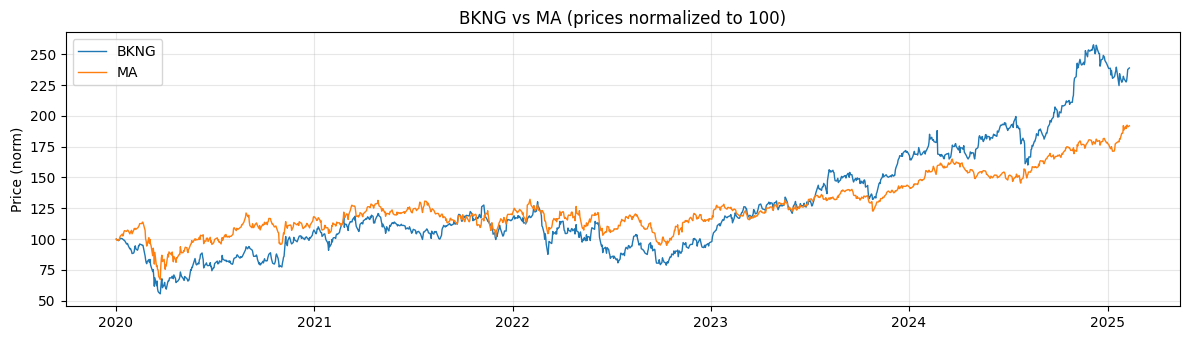

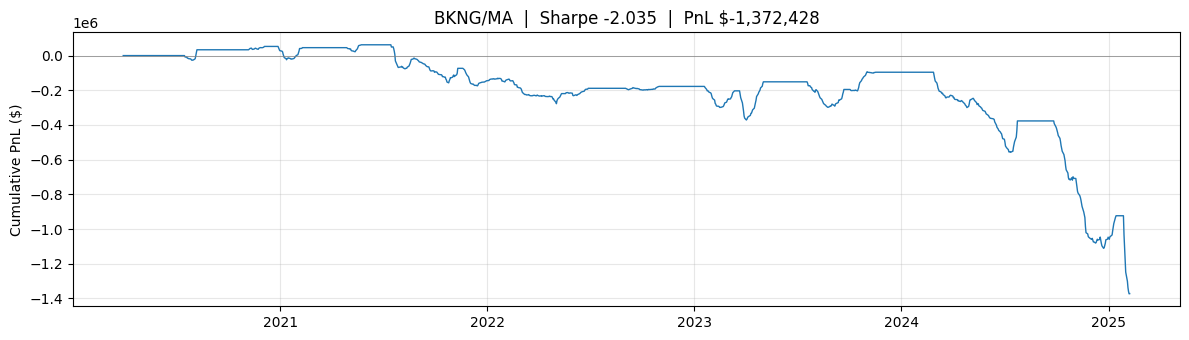

In [88]:
import matplotlib.pyplot as plt

# ── Ticker prices (normalized to 100 at start) ─────────────────────────────
fig1, axes1 = plt.subplots(len(PAIRS), 1, figsize=(12, 3.5 * len(PAIRS)), sharex=True)
if len(PAIRS) == 1:
    axes1 = [axes1]
for ax, (ticker_a, ticker_b) in zip(axes1, PAIRS):
    for col, label in [(ticker_a, ticker_a), (ticker_b, ticker_b)]:
        if col in wide.columns:
            s = wide[col].dropna()
            norm = (s / s.iloc[0]) * 100
            ax.plot(norm.index, norm.values, label=label, linewidth=1)
    ax.set_title(f"{ticker_a} vs {ticker_b} (prices normalized to 100)")
    ax.set_ylabel("Price (norm)")
    ax.legend(loc="upper left")
    ax.grid(alpha=0.3)
fig1.tight_layout()
plt.show()

# ── Cumulative PnL ───────────────────────────────────────────────────────
fig, axes = plt.subplots(len(results), 1, figsize=(12, 3.5 * len(results)), sharex=False)
if len(results) == 1:
    axes = [axes]

for ax, res in zip(axes, results):
    if "pnl_series" not in res:
        ax.set_title(f"{res['pair']} — {res.get('error', 'no data')}")
        continue
    cum = res["pnl_series"].cumsum()
    ax.plot(cum.index, cum.values, linewidth=1)
    ax.set_title(f"{res['pair']}  |  Sharpe {res['sharpe']}  |  PnL ${res['total_pnl']:,.0f}")
    ax.set_ylabel("Cumulative PnL ($)")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.grid(alpha=0.3)

fig.tight_layout()
plt.show()